In [209]:
import warnings
warnings.filterwarnings('ignore')
from numpy import set_printoptions
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
pd.options.display.max_columns=None
import seaborn as sns 
from pandas import read_csv
import io
import base64
import json
from openpyxl import Workbook
from openpyxl.drawing.image import Image as XLImage

import os
import os.path

from urllib.error import HTTPError

from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from googleapiclient.http import MediaIoBaseDownload

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import mean_squared_log_error, median_absolute_error
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel

### CARGUE DE DATOS Y CONEXIÓN A DRIVE

In [2]:
SCOPES = ['https://www.googleapis.com/auth/drive.readonly']

creds = None
if os.path.exists('token.json'):
    creds = Credentials.from_authorized_user_file('token.json', SCOPES)
if not creds or not creds.valid:
    if creds and creds.expired and creds.refresh_token:
        creds.refresh(Request())
    else:
        flow = InstalledAppFlow.from_client_secrets_file('C:/Users/Intevo/Desktop/UNIVERSIDAD DISTRITAL PROYECTO FOLDER/credentials.json', SCOPES) # Reemplazar con la ruta correcta
        creds = flow.run_local_server(port=0)
    with open('C:/Users/Intevo/Desktop/UNIVERSIDAD DISTRITAL PROYECTO FOLDER/token.json', 'w') as token:
        token.write(creds.to_json())
        
# Crear una instancia de la API de Drive
drive_service = build('drive', 'v3', credentials=creds)

# ID de la carpeta de Google Drive
folder_id = '1hQeetmO4XIObUefS_nzePqKqq3VksUEC'

# Ruta de destino para guardar los archivos descargados
save_path = 'C:/Users/Intevo/Desktop/UNIVERSIDAD DISTRITAL PROYECTO FOLDER/UNIVERSIDAD-DISTRITAL-PROYECTO/MÓDULO ANALÍTICA PREDICTIVA/DATOS'  # Reemplazar con la ruta deseada

# Función para descargar archivos de la carpeta de Drive
def download_folder(folder_id, save_path):
    results = drive_service.files().list(
        q=f"'{folder_id}' in parents and trashed=false",
        fields='files(id, name)').execute()
    items = results.get('files', [])
    for item in items:
        file_id = item['id']
        file_name = item['name']
        request = drive_service.files().get_media(fileId=file_id)
        fh = io.FileIO(os.path.join(save_path, file_name), 'wb')
        downloader = MediaIoBaseDownload(fh, request)
        done = False
        while done is False:
            status, done = downloader.next_chunk()
            print(f"Descargando {file_name}: {int(status.progress() * 100)}%")
    print("Descarga completa")

# Descargar archivos de la carpeta
download_folder(folder_id, save_path)

# Listar archivos descargados
files = os.listdir(save_path)
print("Archivos descargados:")
for file in files:
    print(file)

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=899973764197-biu188dkvsgi2al0fh29udm7keak0lh0.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A60459%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.readonly&state=TIzM8jKpu9EJJHGGNnLi9by4vw5vhw&access_type=offline
Descargando Limpieza de datos 1 UD.ipynb: 100%
Descargando industrial10.csv: 100%
Descargando industrial6.csv: 100%
Descargando industrial5.csv: 100%
Descargando industrial9.csv: 100%
Descargando industrial8.csv: 100%
Descargando industrial7.csv: 100%
Descargando industrial2.csv: 100%
Descargando industrial4.csv: 100%
Descargando industrial3.csv: 100%
Descargando industrial1.csv: 100%
Descargando sistemas10.csv: 100%
Descargando sistemas6.csv: 100%
Descargando sistemas2.csv: 100%
Descargando sistemas7.csv: 100%
Descargando sistemas4.csv: 100%
Descargando sistemas9.csv: 100%
Descargando sistemas5.csv: 100%
Descargando sistemas3.c

In [95]:

variables_por_carrera = {
    'industrial': {
        '1': ['PG_ICFES', 'CON_MAT_ICFES', 'FISICA_ICFES','QUIMICA_ICFES','IDIOMA_ICFES','LOCALIDAD', 'PROMEDIO_UNO'],
        '2': ['LOCALIDAD_COLEGIO', 'PG_ICFES', 'CON_MAT_ICFES', 'FISICA_ICFES', 'BIOLOGIA_ICFES', 'IDIOMA_ICFES', 'LOCALIDAD', 'PROMEDIO_UNO', 'CAR_UNO', 'NCC_UNO', 'NAA_UNO', 'NOTA_DIFERENCIAL', 'NOTA_DIBUJO', 'NOTA_QUIMICA', 'NOTA_CFJC', 'NOTA_TEXTOS', 'NOTA_SEMINARIO', 'NOTA_EE_UNO','PROMEDIO_DOS'],
        '3': ['PROMEDIO_UNO', 'NAA_UNO', 'NOTA_DIFERENCIAL', 'NOTA_DIBUJO', 'NOTA_TEXTOS', 'NOTA_EE_UNO', 'PROMEDIO_DOS', 'NCC_DOS', 'NCA_DOS', 'NAA_DOS', 'NOTA_ALGEBRA', 'NOTA_INTEGRAL', 'NOTA_MATERIALES', 'NOTA_PBASICA', 'NOTA_EE_DOS', 'PROMEDIO_TRES'],
        '4': ['PROMEDIO_UNO', 'NOTA_EE_UNO', 'PROMEDIO_DOS', 'NOTA_ALGEBRA', 'NOTA_INTEGRAL', 'NOTA_MATERIALES', 'NOTA_EE_DOS', 'NAA_TRES', 'NOTA_MULTIVARIADO', 'NOTA_ESTADISTICA_UNO', 'NOTA_TERMODINAMICA', 'NOTA_TGS', 'NOTA_EE_TRES','PROMEDIO_CUATRO'],
        '5': ['PROMEDIO_UNO', 'PROMEDIO_DOS', 'NOTA_ALGEBRA', 'NOTA_INTEGRAL', 'NOTA_MATERIALES', 'NOTA_EE_DOS','PROMEDIO_TRES', 'NAA_TRES', 'NOTA_MULTIVARIADO', 'NOTA_TERMODINAMICA', 'NOTA_ECUACIONES', 'NOTA_ESTADISTICA_DOS', 'NOTA_FISICA_DOS', 'NOTA_MECANICA', 'NOTA_PROCESOSQ','PROMEDIO_CINCO'],
        '6': ['PROMEDIO_UNO', 'PROMEDIO_DOS', 'NOTA_MATERIALES', 'NOTA_EE_DOS', 'PROMEDIO_TRES', 'NOTA_MULTIVARIADO', 'NOTA_FISICA_DOS', 'NOTA_EE_CUATRO', 'PROMEDIO_CINCO', 'NOTA_PROCESOSM', 'NOTA_ADMINISTRACION', 'NOTA_LENGUA_UNO', 'NOTA_EI_UNO', 'NOTA_EI_DOS', 'PROMEDIO_SEIS'],
        '7': ['PROMEDIO_UNO', 'PROMEDIO_DOS', 'NOTA_EE_DOS', 'PROMEDIO_TRES', 'NOTA_MULTIVARIADO', 'NOTA_FISICA_DOS', 'PROMEDIO_CINCO', 'NOTA_PROCESOSM', 'NOTA_LENGUA_UNO', 'NOTA_EI_DOS', 'PROMEDIO_SEIS', 'NCA_SEIS', 'NOTA_PLINEAL', 'NOTA_DISENO', 'NOTA_EI_TRES','PROMEDIO_SIETE'],
        '8': ['PROMEDIO_DOS', 'NOTA_EE_CUATRO', 'PROMEDIO_CINCO', 'NOTA_LENGUA_UNO','PROMEDIO_SEIS', 'NOTA_IECONOMICA', 'PROMEDIO_SIETE', 'NAA_SIETE', 'NOTA_GRAFOS', 'NOTA_CALIDAD_UNO', 'NOTA_ERGONOMIA', 'NOTA_EI_CINCO', 'PROMEDIO_OCHO'],
        '9': ['PROMEDIO_DOS', 'NOTA_EE_CUATRO', 'PROMEDIO_CINCO', 'PROMEDIO_SEIS', 'NOTA_IECONOMICA', 'PROMEDIO_SIETE', 'NAA_SIETE', 'NOTA_GRAFOS', 'NOTA_CALIDAD_UNO', 'NOTA_ERGONOMIA', 'NOTA_EI_CINCO', 'PROMEDIO_OCHO', 'NCC_OCHO', 'NOTA_LOG_UNO', 'NOTA_GOPERACIONES','NOTA_CALIDAD_DOS', 'NOTA_LENGUA_DOS', 'NOTA_CONTEXTO','PROMEDIO_NUEVE'],
        '10': ['PROMEDIO_SEIS', 'PROMEDIO_SIETE', 'PROMEDIO_OCHO', 'NOTA_CALIDAD_DOS', 'PROMEDIO_NUEVE', 'NAA_NUEVE', 'NOTA_GRADO_UNO', 'NOTA_LOG_DOS', 'NOTA_FINANZAS', 'NOTA_HISTORIA', 'PROMEDIO_DIEZ']
    },
    'sistemas': {
        '1': ['LOCALIDAD_COLEGIO', 'PG_ICFES', 'CON_MAT_ICFES', 'FISICA_ICFES', 'QUIMICA_ICFES', 'IDIOMA_ICFES', 'LOCALIDAD','PROMEDIO_UNO'],
        '2': ['LOCALIDAD_COLEGIO', 'PG_ICFES', 'CON_MAT_ICFES', 'IDIOMA_ICFES', 'PROMEDIO_UNO', 'NOTA_DIFERENCIAL', 'NOTA_PROG_BASICA', 'NOTA_CATEDRA_FJC', 'NOTA_TEXTOS', 'NOTA_SEMINARIO', 'NOTA_CATEDRA_DEM', 'NOTA_CATEDRA_CON', 'NOTA_LOGICA','PROMEDIO_DOS'],
        '3': ['LOCALIDAD_COLEGIO', 'PG_ICFES', 'CON_MAT_ICFES', 'IDIOMA_ICFES', 'PROMEDIO_UNO', 'PROMEDIO_DOS', 'NOTA_PROG_BASICA', 'NOTA_TEXTOS', 'NOTA_CATEDRA_DEM', 'NOTA_INTEGRAL', 'NOTA_PROG_ORIENTADA', 'NOTA_ETICA', 'PROMEDIO_TRES'],
        '4': ['LOCALIDAD_COLEGIO', 'PG_ICFES', 'CON_MAT_ICFES', 'IDIOMA_ICFES', 'PROMEDIO_UNO', 'PROMEDIO_DOS', 'PROMEDIO_TRES', 'NOTA_PROG_BASICA', 'NOTA_TEXTOS', 'NOTA_CATEDRA_DEM', 'NOTA_INTEGRAL', 'NOTA_PROG_ORIENTADA', 'NOTA_ETICA', 'NOTA_FISICA_DOS', 'NOTA_TGS', 'NOTA_PROG_AVANZADA', 'PROMEDIO_CUATRO'],
        '5': ['PROMEDIO_UNO', 'PROMEDIO_DOS', 'NOTA_ALGEBRA', 'NOTA_INTEGRAL', 'NOTA_MATERIALES', 'NOTA_EE_DOS', 'PROMEDIO_TRES', 'NAA_TRES', 'NOTA_MULTIVARIADO', 'NOTA_TERMODINAMICA', 'NOTA_ECUACIONES', 'NOTA_ESTADISTICA_DOS', 'NOTA_FISICA_DOS', 'NOTA_MECANICA', 'NOTA_PROCESOSQ', 'PROMEDIO_CINCO'],
        '6': ['PROMEDIO_UNO', 'NOTA_EE_UNO', 'PROMEDIO_DOS', 'NOTA_MATERIALES', 'NOTA_EE_DOS', 'PROMEDIO_TRES', 'NOTA_MULTIVARIADO', 'NOTA_ECONOMIA_UNO', 'NOTA_FISICA_DOS', 'NOTA_EE_CUATRO', 'PROMEDIO_CINCO', 'NOTA_PROCESOSM', 'NOTA_ADMINISTRACION', 'NOTA_LENGUA_UNO', 'NOTA_EI_UNO', 'NOTA_EI_DOS','PROMEDIO_SEIS'],
        '7': ['PROMEDIO_UNO', 'PROMEDIO_DOS', 'NOTA_EE_DOS', 'PROMEDIO_TRES', 'NOTA_MULTIVARIADO', 'NOTA_FISICA_DOS', 'PROMEDIO_CINCO', 'NOTA_PROCESOSM', 'NOTA_LENGUA_UNO', 'NOTA_EI_DOS', 'PROMEDIO_SEIS', 'NCA_SEIS', 'NOTA_PLINEAL', 'NOTA_DISE O', 'NOTA_EI_TRES','PROMEDIO_SIETE'],
        '8': ['PROMEDIO_UNO', 'PROMEDIO_DOS', 'NOTA_EE_DOS', 'PROMEDIO_TRES', 'NOTA_MULTIVARIADO', 'NOTA_FISICA_DOS', 'NOTA_EE_CUATRO', 'PROMEDIO_CINCO', 'NOTA_LENGUA_UNO', 'PROMEDIO_SEIS', 'NOTA_IECONOMICA', 'PROMEDIO_SIETE', 'NAA_SIETE', 'NOTA_GRAFOS', 'NOTA_CALIDAD_UNO', 'NOTA_ERGONOMIA', 'NOTA_EI_CINCO', 'PROMEDIO_OCHO'],
        '9': ['PROMEDIO_DOS', 'NOTA_EE_CUATRO', 'PROMEDIO_CINCO', 'PROMEDIO_SEIS', 'NOTA_IECONOMICA', 'PROMEDIO_SIETE', 'NAA_SIETE', 'NOTA_GRAFOS', 'NOTA_CALIDAD_UNO', 'NOTA_ERGONOMIA', 'NOTA_EI_CINCO', 'PROMEDIO_OCHO', 'NCC_OCHO', 'NOTA_LOG_UNO', 'NOTA_GOPERACIONES', 'NOTA_CALIDAD_DOS', 'NOTA_LENGUA_DOS', 'NOTA_CONTEXTO', 'PROMEDIO_NUEVE'],
        '10': ['PROMEDIO_SEIS', 'PROMEDIO_SIETE', 'PROMEDIO_OCHO', 'NOTA_CALIDAD_DOS', 'PROMEDIO_NUEVE', 'NAA_NUEVE', 'NOTA_GRADO_UNO', 'NOTA_LOG_DOS', 'NOTA_FINANZAS', 'NOTA_HISTORIA','PROMEDIO_DIEZ']
    },
    'catastral': {
        '1': ['variable1_catastral', 'variable2_catastral', 'variable3_catastral'],
        '2': ['variable4_catastral', 'variable5_catastral', 'variable6_catastral']
    }
}


In [122]:
def cargar_datos(carrera, semestre):
    
    ruta_archivo = f'C:/Users/Intevo/Desktop/UNIVERSIDAD DISTRITAL PROYECTO FOLDER/UNIVERSIDAD-DISTRITAL-PROYECTO/MÓDULO ANALÍTICA PREDICTIVA/DATOS/{carrera}{semestre}.csv'
    datos = pd.read_csv(ruta_archivo,sep=";")
    
    return datos
carrera="industrial"
semestre="2"

In [123]:
datos = cargar_datos(carrera, semestre)
columnas_filtradas = variables_por_carrera[carrera][semestre]
df = datos[columnas_filtradas]
print("DataFrame con columnas filtradas:")
df=df.astype(int)
df

DataFrame con columnas filtradas:


,LOCALIDAD_COLEGIO,PG_ICFES,CON_MAT_ICFES,FISICA_ICFES,BIOLOGIA_ICFES,IDIOMA_ICFES,LOCALIDAD,PROMEDIO_UNO,CAR_UNO,NCC_UNO,NAA_UNO,NOTA_DIFERENCIAL,NOTA_DIBUJO,NOTA_QUIMICA,NOTA_CFJC,NOTA_TEXTOS,NOTA_SEMINARIO,NOTA_EE_UNO,PROMEDIO_DOS
0,20,472,65,63,59,62,8,39,0,9,4,35,0,45,40,0,40,0,11
1,0,478,62,58,59,53,8,31,1,19,6,22,30,40,35,30,40,36,31
2,20,465,78,66,49,88,19,30,1,21,5,30,23,35,40,15,40,40,26
3,10,491,72,56,65,53,10,31,1,21,5,20,40,35,40,30,40,0,33
4,20,464,67,64,62,53,20,36,0,15,7,30,35,40,40,35,35,45,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2634,0,342,68,0,68,58,11,31,0,10,4,24,33,0,35,37,43,0,0
2635,0,347,69,0,71,71,19,36,0,15,6,41,28,30,38,39,48,38,29
2636,0,348,67,0,67,68,11,29,0,13,4,25,36,30,30,27,37,0,0
2637,0,340,70,0,67,63,11,31,0,10,4,28,33,0,34,30,39,0,0


In [124]:
def numero_a_letras(numero):
    numeros_letras = ['cero', 'uno', 'dos', 'tres', 'cuatro', 'cinco', 'seis', 'siete', 'ocho', 'nueve', 'diez']
    return numeros_letras[int(numero)]

semestre_en_letras = numero_a_letras(semestre)
print(semestre_en_letras)


dos


In [125]:
X = df.loc[:, ~df.columns.str.contains(f'PROMEDIO_{semestre_en_letras.upper()}')]
Y = df.loc[:, df.columns.str.contains(f'PROMEDIO_{semestre_en_letras.upper()}')]                                                     
print("Separación de datos usando Pandas") 
print(X.shape, Y.shape)

Separación de datos usando Pandas
(2639, 18) (2639, 1)


In [126]:
X = X.astype('float32')                         
Y = LabelEncoder().fit_transform(Y.astype('str'))                
print(X.shape, Y.shape)

(2639, 18) (2639,)


<Axes: >

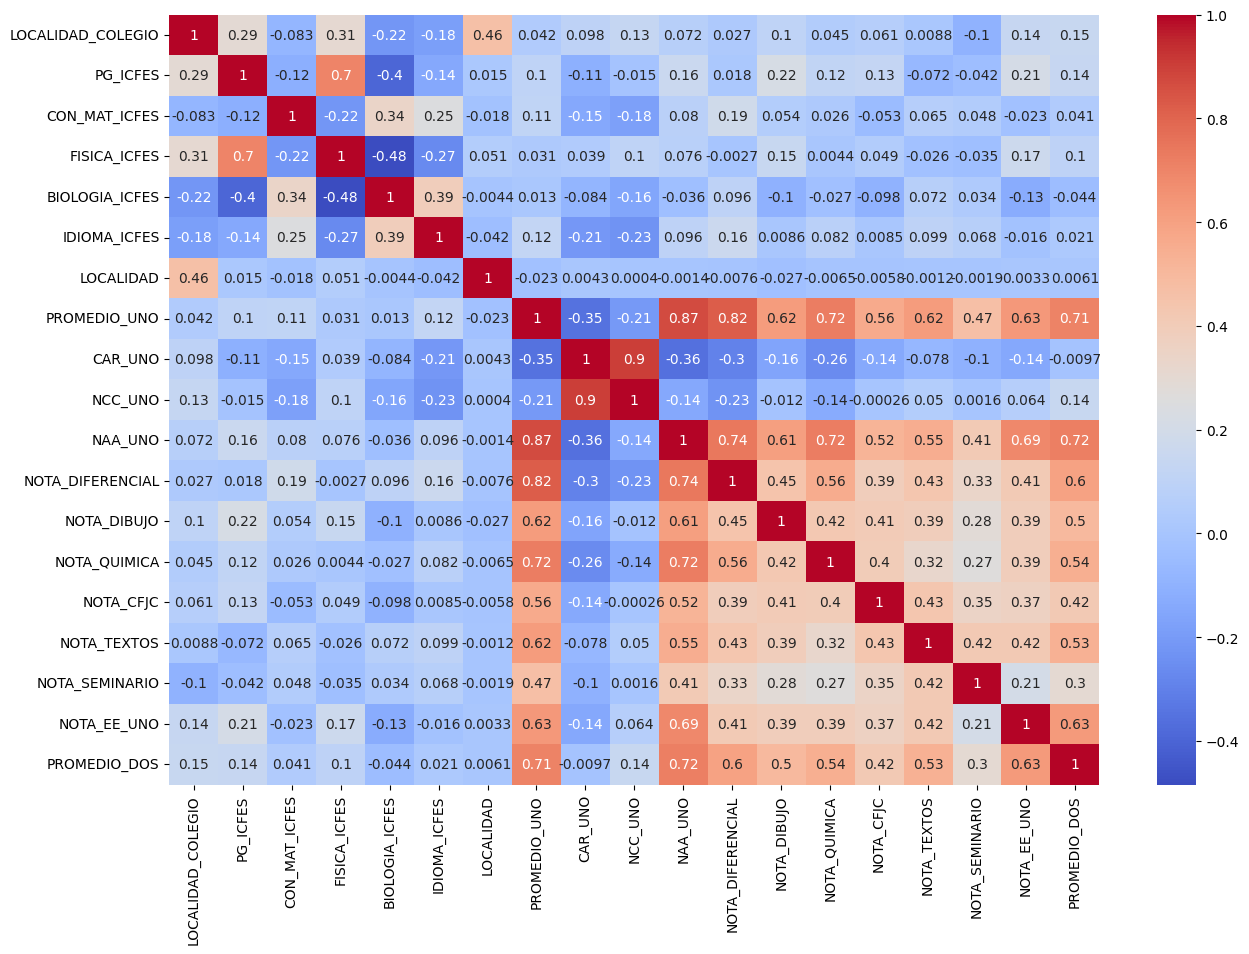

In [127]:
fig, ax = plt.subplots(figsize = (15, 10))
correlacion=df.corr(method='spearman')
sns.heatmap(correlacion,xticklabels=correlacion.columns,yticklabels=correlacion.columns,cmap='coolwarm',annot=True)

In [128]:
X_T_JOHNSON1 = X.copy(deep=True)
def transformacion_johnson(X):
    transformador_johnson = PowerTransformer(method='yeo-johnson', standardize=True).fit(X)
    datos_transformados = transformador_johnson.transform(X)
    set_printoptions(precision=3)
    print(datos_transformados[:5, :])
    datos_transformados_df = pd.DataFrame(data=datos_transformados, columns=X.columns)
    return datos_transformados_df
Xpandas_T_JOHNSON1 = transformacion_johnson(X_T_JOHNSON1)
Xpandas_T_JOHNSON1.head(2)

[[ 1.220e+00  1.211e+00 -6.616e-01  7.632e-01 -3.457e-01 -1.739e-03
  -6.865e-01  1.419e+00 -1.149e+00 -2.320e+00 -5.930e-01  9.885e-01
  -2.310e+00  2.012e+00  4.505e-01 -2.261e+00  4.796e-01 -1.137e+00]
 [-1.675e+00  1.339e+00 -9.879e-01  6.658e-01 -3.457e-01 -7.067e-01
  -6.865e-01 -1.514e-01  1.495e-01  2.141e-01  5.492e-01 -5.261e-01
  -2.822e-01  1.378e+00 -3.776e-01 -4.596e-01  4.796e-01  7.941e-01]
 [ 1.220e+00  1.062e+00  7.691e-01  8.197e-01 -1.556e+00  2.110e+00
   1.199e+00 -3.103e-01  1.495e-01  5.505e-01 -5.578e-02  3.773e-01
  -9.902e-01  7.732e-01  4.505e-01 -1.622e+00  4.796e-01  8.704e-01]
 [-2.308e-02  1.622e+00  1.055e-01  6.257e-01  3.518e-01 -7.067e-01
  -3.061e-01 -1.514e-01  1.495e-01  5.505e-01 -5.578e-02 -7.358e-01
   9.297e-01  7.732e-01  4.505e-01 -4.596e-01  4.796e-01 -1.137e+00]
 [ 1.220e+00  1.041e+00 -4.432e-01  7.822e-01  5.507e-03 -7.067e-01
   1.352e+00  7.658e-01 -1.149e+00 -5.846e-01  1.219e+00  3.773e-01
   2.954e-01  1.378e+00  4.505e-01  1.414e-0

,LOCALIDAD_COLEGIO,PG_ICFES,CON_MAT_ICFES,FISICA_ICFES,BIOLOGIA_ICFES,IDIOMA_ICFES,LOCALIDAD,PROMEDIO_UNO,CAR_UNO,NCC_UNO,NAA_UNO,NOTA_DIFERENCIAL,NOTA_DIBUJO,NOTA_QUIMICA,NOTA_CFJC,NOTA_TEXTOS,NOTA_SEMINARIO,NOTA_EE_UNO
0,1.219727,1.210544,-0.661599,0.763178,-0.345683,-0.001739,-0.686483,1.419251,-1.148729,-2.319642,-0.592996,0.988491,-2.309741,2.011675,0.450522,-2.261243,0.479632,-1.136821
1,-1.674688,1.339302,-0.987923,0.665835,-0.345683,-0.706695,-0.686483,-0.151395,0.149489,0.214130,0.549188,-0.526053,-0.282213,1.377705,-0.377645,-0.459550,0.479632,0.794119


In [129]:
X_trn, X_tst, Y_trn, Y_tst = train_test_split(Xpandas_T_JOHNSON1, Y, test_size=0.3, random_state=2)
print('DATOS: Son {} datos para entrenamiento y {} datos para prueba'.format(X_trn.shape[0], X_tst.shape[0]))

DATOS: Son 1847 datos para entrenamiento y 792 datos para prueba


In [130]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

### KNEIGHBORSREGRESSOR

In [131]:
# conocer los hiperparámetro de cada algoritmo
estimator = KNeighborsRegressor()
estimator.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [132]:
def entrenar_modelo_knn_con_transformacion(X_trn, Y_trn):
    X_trn_transformado = X_trn
    parameters = {
        'n_neighbors': [i for i in range(1, 18, 1)],
        'metric': ['euclidean', 'manhattan', 'minkowski'],
        'algorithm': ['auto'],
        'p': [i for i in range(1, 6)],
        'weights': ['uniform']
    }
    modelo = KNeighborsRegressor()
    semilla = 5
    num_folds = 10
    kfold =StratifiedKFold(n_splits=num_folds, random_state=semilla, shuffle=True)
    metrica = 'neg_mean_squared_error'
    grid = GridSearchCV(estimator=modelo, param_grid=parameters, scoring=metrica, cv=kfold, n_jobs=-1)
    grid_resultado = grid.fit(X_trn_transformado, Y_trn)
    mejor_modelo = KNeighborsRegressor(**grid_resultado.best_params_)
    mejor_modelo.fit(X_trn_transformado, Y_trn)
    mejores_hiperparametros_knn=grid_resultado.best_params_
    return mejor_modelo,grid_resultado.best_params_

modelo_knn,mejores_hiperparametros_knn  = entrenar_modelo_knn_con_transformacion(X_trn, Y_trn)
mejores_hiperparametros_knn 

{'algorithm': 'auto',
 'metric': 'manhattan',
 'n_neighbors': 13,
 'p': 1,
 'weights': 'uniform'}

In [137]:
# Predecir las etiquetas para los datos de prueba
resultados_df_knn = pd.DataFrame(columns=['MÉTRICA', 'VALOR'])
# Predicciones del modelo
Y_pred = modelo_knn.predict(X_trn)

# Cálculo de métricas
mse = mean_squared_error(Y_trn, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_trn, Y_pred)
r2 = r2_score(Y_trn, Y_pred)
msle = mean_squared_log_error(Y_trn, Y_pred)
rmsle = np.sqrt(msle)
n = len(Y_trn)
k = X_trn.shape[1]
r2_ajustado = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Crear un DataFrame para cada métrica
df_MSE = pd.DataFrame({'MÉTRICA': ['Error Cuadrático Medio (MSE)'], 'VALOR': [round(mse, 2)]})
df_RMSE= pd.DataFrame({'MÉTRICA': ['Raíz del Error Cuadrático Medio (RMSE)'], 'VALOR': [round(rmse, 2)]})
df_MAE = pd.DataFrame({'MÉTRICA': ['Error Absoluto Medio (MAE)'], 'VALOR': [round(mae, 2)]})
df_R2 = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación'], 'VALOR': [round(r2*100, 2)]})
df_R2A = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación Ajustado'], 'VALOR': [round(r2_ajustado*100, 2)]})
df_MSLE=pd.DataFrame({'MÉTRICA': ['Error Logarítmico Cuadrático Medio (MSLE)'], 'VALOR': [round(msle*100, 2)]})
df_RMSLE=pd.DataFrame({'MÉTRICA': ['Raíz del Error Logarítmico Cuadrático Medio (RMSLE)'], 'VALOR': [round(rmsle*100, 2)]})
# Concatenar los DataFrames
resultados_df_knn_entrenamiento = pd.concat([resultados_df_knn, df_MSE,df_RMSE,df_MAE,df_R2,df_R2A,df_MSLE,df_RMSLE], ignore_index=True)
resultados_df_knn_entrenamiento["MODELO"]='KNeighbors'
resultados_df_knn_entrenamiento["TIPO_DE_DATOS"]='Entrenamiento'
# Imprimir el DataFrame con los resultados
resultados_df_knn_entrenamiento

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),42.48,KNeighbors,Entrenamiento
1,Raíz del Error Cuadrático Medio (RMSE),6.52,KNeighbors,Entrenamiento
2,Error Absoluto Medio (MAE),4.13,KNeighbors,Entrenamiento
3,Coeficiente de Determinación,71.75,KNeighbors,Entrenamiento
4,Coeficiente de Determinación Ajustado,71.47,KNeighbors,Entrenamiento
5,Error Logarítmico Cuadrático Medio (MSLE),53.39,KNeighbors,Entrenamiento
6,Raíz del Error Logarítmico Cuadrático Medio (R...,73.07,KNeighbors,Entrenamiento


In [138]:
# Predecir las etiquetas para los datos de prueba
resultados_df_knn = pd.DataFrame(columns=['MÉTRICA', 'VALOR'])
# Predicciones del modelo
Y_pred = modelo_knn.predict(X_tst)

# Cálculo de métricas
mse = mean_squared_error(Y_tst, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_tst, Y_pred)
r2 = r2_score(Y_tst, Y_pred)
msle = mean_squared_log_error(Y_tst, Y_pred)
rmsle = np.sqrt(msle)
n = len(Y_tst)
k = X_tst.shape[1]
r2_ajustado = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Crear un DataFrame para cada métrica
df_MSE = pd.DataFrame({'MÉTRICA': ['Error Cuadrático Medio (MSE)'], 'VALOR': [round(mse, 2)]})
df_RMSE= pd.DataFrame({'MÉTRICA': ['Raíz del Error Cuadrático Medio (RMSE)'], 'VALOR': [round(rmse, 2)]})
df_MAE = pd.DataFrame({'MÉTRICA': ['Error Absoluto Medio (MAE)'], 'VALOR': [round(mae, 2)]})
df_R2 = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación'], 'VALOR': [round(r2*100, 2)]})
df_R2A = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación Ajustado'], 'VALOR': [round(r2_ajustado*100, 2)]})
df_MSLE=pd.DataFrame({'MÉTRICA': ['Error Logarítmico Cuadrático Medio (MSLE)'], 'VALOR': [round(msle*100, 2)]})
df_RMSLE=pd.DataFrame({'MÉTRICA': ['Raíz del Error Logarítmico Cuadrático Medio (RMSLE)'], 'VALOR': [round(rmsle*100, 2)]})
# Concatenar los DataFrames
resultados_df_knn_prueba = pd.concat([resultados_df_knn, df_MSE,df_RMSE,df_MAE,df_R2,df_R2A,df_MSLE,df_RMSLE], ignore_index=True)
resultados_df_knn_prueba["MODELO"]='KNeighbors'
resultados_df_knn_prueba["TIPO_DE_DATOS"]='Prueba'
# Imprimir el DataFrame con los resultados
resultados_df_knn_prueba

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),55.63,KNeighbors,Prueba
1,Raíz del Error Cuadrático Medio (RMSE),7.46,KNeighbors,Prueba
2,Error Absoluto Medio (MAE),4.65,KNeighbors,Prueba
3,Coeficiente de Determinación,61.22,KNeighbors,Prueba
4,Coeficiente de Determinación Ajustado,60.32,KNeighbors,Prueba
5,Error Logarítmico Cuadrático Medio (MSLE),57.11,KNeighbors,Prueba
6,Raíz del Error Logarítmico Cuadrático Medio (R...,75.57,KNeighbors,Prueba


In [139]:
mejores_hiperparametros_knn = modelo_knn.get_params()
mejores_hiperparametros_knn

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'manhattan',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 13,
 'p': 1,
 'weights': 'uniform'}

In [140]:
cadena_hiperparametros_knn = ', '.join([f"{key}: {value}" for key, value in mejores_hiperparametros_knn.items()])
df_hiperparametros_knn = pd.DataFrame({
    'MÉTRICA': ['Mejores Hiperparametros'],
    'VALOR': [cadena_hiperparametros_knn],
    'MODELO': ['KNeighbors'],
    'TIPO_DE_DATOS': ['Entrenamiento']
})
resultados_df_knn = pd.concat([resultados_df_knn_prueba,resultados_df_knn_entrenamiento,df_hiperparametros_knn], ignore_index=True)
resultados_df_knn['TIPO_DE_DATOS']=np.where(resultados_df_knn['MÉTRICA']=='Mejores Hiperparametros','Hiperparametros del modelo',resultados_df_knn['TIPO_DE_DATOS'])
resultados_df_knn

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),55.63,KNeighbors,Prueba
1,Raíz del Error Cuadrático Medio (RMSE),7.46,KNeighbors,Prueba
2,Error Absoluto Medio (MAE),4.65,KNeighbors,Prueba
3,Coeficiente de Determinación,61.22,KNeighbors,Prueba
4,Coeficiente de Determinación Ajustado,60.32,KNeighbors,Prueba
5,Error Logarítmico Cuadrático Medio (MSLE),57.11,KNeighbors,Prueba
6,Raíz del Error Logarítmico Cuadrático Medio (R...,75.57,KNeighbors,Prueba
7,Error Cuadrático Medio (MSE),42.48,KNeighbors,Entrenamiento
8,Raíz del Error Cuadrático Medio (RMSE),6.52,KNeighbors,Entrenamiento
9,Error Absoluto Medio (MAE),4.13,KNeighbors,Entrenamiento


### SVR

In [141]:
from sklearn.svm import SVR
estimator = SVR()
estimator.get_params()

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [143]:
def entrenar_modelo_svc_con_transformacion(X_trn, Y_trn):
    X_trn_transformado = X_trn
    parameters = { 'kernel':  ['rbf', 'poly', 'sigmoid','linear'], 
            'C': [i/10000 for i in range(8,12,1)],
            'max_iter':[i for i in range(1,3,1)],
            'gamma' : [i/100 for i in range(90,110,5)]}
    modelo = SVR()
    semilla=5
    num_folds=10
    kfold =StratifiedKFold(n_splits=num_folds, random_state=semilla, shuffle=True)
    metrica = 'neg_mean_squared_error'
    grid = GridSearchCV(estimator=modelo, param_grid=parameters, scoring=metrica, cv=kfold, n_jobs=-1)
    grid_resultado = grid.fit(X_trn_transformado, Y_trn)
    mejor_modelo = SVR(**grid_resultado.best_params_)
    mejor_modelo.fit(X_trn_transformado, Y_trn)
    mejores_hiperparametros_svc=grid_resultado.best_params_
    return mejor_modelo,grid_resultado.best_params_

modelo_svc,mejores_hiperparametros_svc = entrenar_modelo_svc_con_transformacion(X_trn, Y_trn)

In [144]:
# Predecir las etiquetas para los datos de prueba
resultados_df_svc = pd.DataFrame(columns=['MÉTRICA', 'VALOR'])
# Predicciones del modelo
Y_pred = modelo_svc.predict(X_trn)

# Cálculo de métricas
mse = mean_squared_error(Y_trn, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_trn, Y_pred)
r2 = r2_score(Y_trn, Y_pred)
msle = mean_squared_log_error(Y_trn, Y_pred)
rmsle = np.sqrt(msle)
n = len(Y_trn)
k = X_trn.shape[1]
r2_ajustado = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Crear un DataFrame para cada métrica
df_MSE = pd.DataFrame({'MÉTRICA': ['Error Cuadrático Medio (MSE)'], 'VALOR': [round(mse, 2)]})
df_RMSE= pd.DataFrame({'MÉTRICA': ['Raíz del Error Cuadrático Medio (RMSE)'], 'VALOR': [round(rmse, 2)]})
df_MAE = pd.DataFrame({'MÉTRICA': ['Error Absoluto Medio (MAE)'], 'VALOR': [round(mae, 2)]})
df_R2 = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación'], 'VALOR': [round(r2*100, 2)]})
df_R2A = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación Ajustado'], 'VALOR': [round(r2_ajustado*100, 2)]})
df_MSLE=pd.DataFrame({'MÉTRICA': ['Error Logarítmico Cuadrático Medio (MSLE)'], 'VALOR': [round(msle*100, 2)]})
df_RMSLE=pd.DataFrame({'MÉTRICA': ['Raíz del Error Logarítmico Cuadrático Medio (RMSLE)'], 'VALOR': [round(rmsle*100, 2)]})
# Concatenar los DataFrames
resultados_df_svc_entrenamiento = pd.concat([resultados_df_svc, df_MSE,df_RMSE,df_MAE,df_R2,df_R2A,df_MSLE,df_RMSLE], ignore_index=True)
resultados_df_svc_entrenamiento["MODELO"]='SVR'
resultados_df_svc_entrenamiento["TIPO_DE_DATOS"]='Entrenamiento'
# Imprimir el DataFrame con los resultados
resultados_df_svc_entrenamiento

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),154.09,SVR,Entrenamiento
1,Raíz del Error Cuadrático Medio (RMSE),12.41,SVR,Entrenamiento
2,Error Absoluto Medio (MAE),10.77,SVR,Entrenamiento
3,Coeficiente de Determinación,-2.47,SVR,Entrenamiento
4,Coeficiente de Determinación Ajustado,-3.48,SVR,Entrenamiento
5,Error Logarítmico Cuadrático Medio (MSLE),194.11,SVR,Entrenamiento
6,Raíz del Error Logarítmico Cuadrático Medio (R...,139.32,SVR,Entrenamiento


In [148]:
# Predecir las etiquetas para los datos de prueba
resultados_df_svc = pd.DataFrame(columns=['MÉTRICA', 'VALOR'])
# Predicciones del modelo
Y_pred = modelo_svc.predict(X_tst)

# Cálculo de métricas
mse = mean_squared_error(Y_tst, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_tst, Y_pred)
r2 = r2_score(Y_tst, Y_pred)
msle = mean_squared_log_error(Y_tst, Y_pred)
rmsle = np.sqrt(msle)
n = len(Y_tst)
k = X_tst.shape[1]
r2_ajustado = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Crear un DataFrame para cada métrica
df_MSE = pd.DataFrame({'MÉTRICA': ['Error Cuadrático Medio (MSE)'], 'VALOR': [round(mse, 2)]})
df_RMSE= pd.DataFrame({'MÉTRICA': ['Raíz del Error Cuadrático Medio (RMSE)'], 'VALOR': [round(rmse, 2)]})
df_MAE = pd.DataFrame({'MÉTRICA': ['Error Absoluto Medio (MAE)'], 'VALOR': [round(mae, 2)]})
df_R2 = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación'], 'VALOR': [round(r2*100, 2)]})
df_R2A = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación Ajustado'], 'VALOR': [round(r2_ajustado*100, 2)]})
df_MSLE=pd.DataFrame({'MÉTRICA': ['Error Logarítmico Cuadrático Medio (MSLE)'], 'VALOR': [round(msle*100, 2)]})
df_RMSLE=pd.DataFrame({'MÉTRICA': ['Raíz del Error Logarítmico Cuadrático Medio (RMSLE)'], 'VALOR': [round(rmsle*100, 2)]})
# Concatenar los DataFrames
resultados_df_svc_prueba = pd.concat([resultados_df_svc, df_MSE,df_RMSE,df_MAE,df_R2,df_R2A,df_MSLE,df_RMSLE], ignore_index=True)
resultados_df_svc_prueba["MODELO"]='SVR'
resultados_df_svc_prueba["TIPO_DE_DATOS"]='Prueba'
# Imprimir el DataFrame con los resultados
resultados_df_svc_prueba

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),148.12,SVR,Prueba
1,Raíz del Error Cuadrático Medio (RMSE),12.17,SVR,Prueba
2,Error Absoluto Medio (MAE),10.44,SVR,Prueba
3,Coeficiente de Determinación,-3.26,SVR,Prueba
4,Coeficiente de Determinación Ajustado,-5.66,SVR,Prueba
5,Error Logarítmico Cuadrático Medio (MSLE),173.53,SVR,Prueba
6,Raíz del Error Logarítmico Cuadrático Medio (R...,131.73,SVR,Prueba


In [149]:
mejores_hiperparametros_svc = modelo_svc.get_params()
mejores_hiperparametros_svc

{'C': 0.0008,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 0.9,
 'kernel': 'poly',
 'max_iter': 1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [150]:
cadena_hiperparametros_svc = ', '.join([f"{key}: {value}" for key, value in mejores_hiperparametros_svc.items()])
df_hiperparametros_svc = pd.DataFrame({
    'MÉTRICA': ['Mejores Hiperparametros'],
    'VALOR': [cadena_hiperparametros_svc],
    'MODELO': ['SVR'],
    'TIPO_DE_DATOS': ['Hiperparametros del modelo']
})
resultados_df_svc = pd.concat([resultados_df_svc_prueba,resultados_df_svc_entrenamiento,df_hiperparametros_svc], ignore_index=True)
resultados_df_svc

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),148.12,SVR,Prueba
1,Raíz del Error Cuadrático Medio (RMSE),12.17,SVR,Prueba
2,Error Absoluto Medio (MAE),10.44,SVR,Prueba
3,Coeficiente de Determinación,-3.26,SVR,Prueba
4,Coeficiente de Determinación Ajustado,-5.66,SVR,Prueba
5,Error Logarítmico Cuadrático Medio (MSLE),173.53,SVR,Prueba
6,Raíz del Error Logarítmico Cuadrático Medio (R...,131.73,SVR,Prueba
7,Error Cuadrático Medio (MSE),154.09,SVR,Entrenamiento
8,Raíz del Error Cuadrático Medio (RMSE),12.41,SVR,Entrenamiento
9,Error Absoluto Medio (MAE),10.77,SVR,Entrenamiento


### DECISION TREE

In [151]:
from sklearn.tree import DecisionTreeRegressor
estimator = DecisionTreeRegressor()
estimator.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': None,
 'splitter': 'best'}

In [152]:
def entrenar_modelo_tree_con_transformacion(X_trn, Y_trn):
    X_trn_transformado = X_trn
    parameters = {          
            'max_depth':[i for i in range(1,7,1)], 
            'min_samples_leaf' : [i for i in range(1,7,1)], 
            'max_features' : [i for i in range(1,7,1)], 
            'splitter': ["best", "random"],
            'random_state': [i for i in range(1,7,1)]}
    modelo = DecisionTreeRegressor()
    semilla=7
    num_folds=10
    kfold = StratifiedKFold(n_splits=num_folds, random_state=semilla, shuffle=True)
    metrica = 'neg_mean_squared_error'
    grid = GridSearchCV(estimator=modelo, param_grid=parameters, scoring=metrica, cv=kfold, n_jobs=-1)
    grid_resultado = grid.fit(X_trn, Y_trn)
    
    mejor_modelo = DecisionTreeRegressor(**grid_resultado.best_params_)
    mejor_modelo.fit(X_trn_transformado, Y_trn)
    mejores_hiperparametros_tree=grid_resultado.best_params_
    return mejor_modelo, grid_resultado.best_params_

modelo_tree,mejores_hiperparametros_tree = entrenar_modelo_tree_con_transformacion(X_trn, Y_trn)
    

In [158]:
# Predecir las etiquetas para los datos de prueba
resultados_df_tree = pd.DataFrame(columns=['MÉTRICA', 'VALOR'])
# Predicciones del modelo
Y_pred = modelo_tree.predict(X_trn)

# Cálculo de métricas
mse = mean_squared_error(Y_trn, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_trn, Y_pred)
r2 = r2_score(Y_trn, Y_pred)
msle = mean_squared_log_error(Y_trn, Y_pred)
rmsle = np.sqrt(msle)
n = len(Y_trn)
k = X_trn.shape[1]
r2_ajustado = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Crear un DataFrame para cada métrica
df_MSE = pd.DataFrame({'MÉTRICA': ['Error Cuadrático Medio (MSE)'], 'VALOR': [round(mse, 2)]})
df_RMSE= pd.DataFrame({'MÉTRICA': ['Raíz del Error Cuadrático Medio (RMSE)'], 'VALOR': [round(rmse, 2)]})
df_MAE = pd.DataFrame({'MÉTRICA': ['Error Absoluto Medio (MAE)'], 'VALOR': [round(mae, 2)]})
df_R2 = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación'], 'VALOR': [round(r2*100, 2)]})
df_R2A = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación Ajustado'], 'VALOR': [round(r2_ajustado*100, 2)]})
df_MSLE=pd.DataFrame({'MÉTRICA': ['Error Logarítmico Cuadrático Medio (MSLE)'], 'VALOR': [round(msle*100, 2)]})
df_RMSLE=pd.DataFrame({'MÉTRICA': ['Raíz del Error Logarítmico Cuadrático Medio (RMSLE)'], 'VALOR': [round(rmsle*100, 2)]})
# Concatenar los DataFrames
resultados_df_tree_entrenamiento = pd.concat([resultados_df_tree, df_MSE,df_RMSE,df_MAE,df_R2,df_R2A,df_MSLE,df_RMSLE], ignore_index=True)
resultados_df_tree_entrenamiento["MODELO"]='DecisionTree'
resultados_df_tree_entrenamiento["TIPO_DE_DATOS"]='Entrenamiento'
# Imprimir el DataFrame con los resultados
resultados_df_tree_entrenamiento

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),41.99,DecisionTree,Entrenamiento
1,Raíz del Error Cuadrático Medio (RMSE),6.48,DecisionTree,Entrenamiento
2,Error Absoluto Medio (MAE),4.22,DecisionTree,Entrenamiento
3,Coeficiente de Determinación,72.08,DecisionTree,Entrenamiento
4,Coeficiente de Determinación Ajustado,71.80,DecisionTree,Entrenamiento
5,Error Logarítmico Cuadrático Medio (MSLE),41.74,DecisionTree,Entrenamiento
6,Raíz del Error Logarítmico Cuadrático Medio (R...,64.60,DecisionTree,Entrenamiento


In [159]:
# Predecir las etiquetas para los datos de prueba
resultados_df_tree = pd.DataFrame(columns=['MÉTRICA', 'VALOR'])
# Predicciones del modelo
Y_pred = modelo_tree.predict(X_tst)

# Cálculo de métricas
mse = mean_squared_error(Y_tst, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_tst, Y_pred)
r2 = r2_score(Y_tst, Y_pred)
msle = mean_squared_log_error(Y_tst, Y_pred)
rmsle = np.sqrt(msle)
n = len(Y_tst)
k = X_tst.shape[1]
r2_ajustado = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Crear un DataFrame para cada métrica
df_MSE = pd.DataFrame({'MÉTRICA': ['Error Cuadrático Medio (MSE)'], 'VALOR': [round(mse, 2)]})
df_RMSE= pd.DataFrame({'MÉTRICA': ['Raíz del Error Cuadrático Medio (RMSE)'], 'VALOR': [round(rmse, 2)]})
df_MAE = pd.DataFrame({'MÉTRICA': ['Error Absoluto Medio (MAE)'], 'VALOR': [round(mae, 2)]})
df_R2 = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación'], 'VALOR': [round(r2*100, 2)]})
df_R2A = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación Ajustado'], 'VALOR': [round(r2_ajustado*100, 2)]})
df_MSLE=pd.DataFrame({'MÉTRICA': ['Error Logarítmico Cuadrático Medio (MSLE)'], 'VALOR': [round(msle*100, 2)]})
df_RMSLE=pd.DataFrame({'MÉTRICA': ['Raíz del Error Logarítmico Cuadrático Medio (RMSLE)'], 'VALOR': [round(rmsle*100, 2)]})
# Concatenar los DataFrames
resultados_df_tree_prueba = pd.concat([resultados_df_tree, df_MSE,df_RMSE,df_MAE,df_R2,df_R2A,df_MSLE,df_RMSLE], ignore_index=True)
resultados_df_tree_prueba["MODELO"]='DecisionTree'
resultados_df_tree_prueba["TIPO_DE_DATOS"]='Prueba'
# Imprimir el DataFrame con los resultados
resultados_df_tree_prueba

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),61.80,DecisionTree,Prueba
1,Raíz del Error Cuadrático Medio (RMSE),7.86,DecisionTree,Prueba
2,Error Absoluto Medio (MAE),4.99,DecisionTree,Prueba
3,Coeficiente de Determinación,56.92,DecisionTree,Prueba
4,Coeficiente de Determinación Ajustado,55.92,DecisionTree,Prueba
5,Error Logarítmico Cuadrático Medio (MSLE),55.58,DecisionTree,Prueba
6,Raíz del Error Logarítmico Cuadrático Medio (R...,74.55,DecisionTree,Prueba


In [160]:
mejores_hiperparametros_tree = modelo_tree.get_params()
mejores_hiperparametros_tree

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 5,
 'max_features': 4,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 6,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 1,
 'splitter': 'best'}

In [161]:
cadena_hiperparametros_tree = ', '.join([f"{key}: {value}" for key, value in mejores_hiperparametros_tree.items()])
df_hiperparametros_tree = pd.DataFrame({
    'MÉTRICA': ['Mejores Hiperparametros'],
    'VALOR': [cadena_hiperparametros_tree],
    'MODELO': ['DecisionTree'],
    'TIPO_DE_DATOS': ['Hiperparametros del modelo']
})
resultados_df_tree = pd.concat([resultados_df_tree_prueba,resultados_df_tree_entrenamiento,df_hiperparametros_tree], ignore_index=True)
resultados_df_tree

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),61.8,DecisionTree,Prueba
1,Raíz del Error Cuadrático Medio (RMSE),7.86,DecisionTree,Prueba
2,Error Absoluto Medio (MAE),4.99,DecisionTree,Prueba
3,Coeficiente de Determinación,56.92,DecisionTree,Prueba
4,Coeficiente de Determinación Ajustado,55.92,DecisionTree,Prueba
5,Error Logarítmico Cuadrático Medio (MSLE),55.58,DecisionTree,Prueba
6,Raíz del Error Logarítmico Cuadrático Medio (R...,74.55,DecisionTree,Prueba
7,Error Cuadrático Medio (MSE),41.99,DecisionTree,Entrenamiento
8,Raíz del Error Cuadrático Medio (RMSE),6.48,DecisionTree,Entrenamiento
9,Error Absoluto Medio (MAE),4.22,DecisionTree,Entrenamiento


### NAIVE BAYES

In [162]:
from sklearn.gaussian_process import GaussianProcessRegressor
estimator =  GaussianProcessRegressor()
estimator.get_params()

{'alpha': 1e-10,
 'copy_X_train': True,
 'kernel': None,
 'n_restarts_optimizer': 0,
 'n_targets': None,
 'normalize_y': False,
 'optimizer': 'fmin_l_bfgs_b',
 'random_state': None}

In [166]:
def entrenar_modelo_gaussian_con_transformacion(X_trn, Y_trn):
    X_trn_transformado = X_trn
    kernel1 = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-4, 1e4))
    kernel2 = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-4, 1e4)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e1))
    parameters = {
        #'kernel': [kernel1, kernel2],
        'alpha': [1e-10, 1e-5, 1e-2, 1e-1],
        'n_restarts_optimizer': [0, 1, 2, 3],
        'normalize_y': [True, False],
        'optimizer': ['fmin_l_bfgs_b']
    }
    modelo = GaussianProcessRegressor()
    semilla=7
    num_folds=10
    kfold =StratifiedKFold(n_splits=num_folds, random_state=semilla, shuffle=True)
    metrica = 'neg_mean_squared_error'
    grid = GridSearchCV(estimator=modelo, param_grid=parameters, scoring=metrica, cv=kfold, n_jobs=-1)
    grid_resultado = grid.fit(X_trn, Y_trn)
    mejor_modelo = GaussianProcessRegressor(**grid_resultado.best_params_)
    mejores_hiperparametros_gaussian=grid_resultado.best_params_
    mejor_modelo.fit(X_trn_transformado, Y_trn)
    return mejor_modelo,grid_resultado.best_params_

modelo_gaussian,mejores_hiperparametros_gaussian = entrenar_modelo_gaussian_con_transformacion(X_trn, Y_trn)

In [169]:
# Predecir las etiquetas para los datos de prueba
resultados_df_gaussian = pd.DataFrame(columns=['MÉTRICA', 'VALOR'])
# Predicciones del modelo
Y_pred = modelo_gaussian.predict(X_trn)

# Cálculo de métricas
mse = mean_squared_error(Y_trn, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_trn, Y_pred)
r2 = r2_score(Y_trn, Y_pred)
#msle = mean_squared_log_error(Y_trn, Y_pred)
rmsle = np.sqrt(msle)
n = len(Y_trn)
k = X_trn.shape[1]
r2_ajustado = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Crear un DataFrame para cada métrica
df_MSE = pd.DataFrame({'MÉTRICA': ['Error Cuadrático Medio (MSE)'], 'VALOR': [round(mse, 2)]})
df_RMSE= pd.DataFrame({'MÉTRICA': ['Raíz del Error Cuadrático Medio (RMSE)'], 'VALOR': [round(rmse, 2)]})
df_MAE = pd.DataFrame({'MÉTRICA': ['Error Absoluto Medio (MAE)'], 'VALOR': [round(mae, 2)]})
df_R2 = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación'], 'VALOR': [round(r2*100, 2)]})
df_R2A = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación Ajustado'], 'VALOR': [round(r2_ajustado*100, 2)]})
df_MSLE=pd.DataFrame({'MÉTRICA': ['Error Logarítmico Cuadrático Medio (MSLE)'], 'VALOR': ['Sin valor']})
df_RMSLE=pd.DataFrame({'MÉTRICA': ['Raíz del Error Logarítmico Cuadrático Medio (RMSLE)'], 'VALOR': [round(rmsle*100, 2)]})
# Concatenar los DataFrames
resultados_df_gaussian_entrenamiento = pd.concat([resultados_df_gaussian, df_MSE,df_RMSE,df_MAE,df_R2,df_R2A,df_MSLE,df_RMSLE], ignore_index=True)
resultados_df_gaussian_entrenamiento["MODELO"]='NaiveBayes'
resultados_df_gaussian_entrenamiento["TIPO_DE_DATOS"]='Entrenamiento'
# Imprimir el DataFrame con los resultados
resultados_df_gaussian_entrenamiento

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),0.0,NaiveBayes,Entrenamiento
1,Raíz del Error Cuadrático Medio (RMSE),0.0,NaiveBayes,Entrenamiento
2,Error Absoluto Medio (MAE),0.0,NaiveBayes,Entrenamiento
3,Coeficiente de Determinación,100.0,NaiveBayes,Entrenamiento
4,Coeficiente de Determinación Ajustado,100.0,NaiveBayes,Entrenamiento
5,Error Logarítmico Cuadrático Medio (MSLE),Sin valor,NaiveBayes,Entrenamiento
6,Raíz del Error Logarítmico Cuadrático Medio (R...,74.55,NaiveBayes,Entrenamiento


In [172]:
# Predecir las etiquetas para los datos de prueba
resultados_df_gaussian = pd.DataFrame(columns=['MÉTRICA', 'VALOR'])
# Predicciones del modelo
Y_pred = modelo_gaussian.predict(X_tst)

# Cálculo de métricas
mse = mean_squared_error(Y_tst, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_tst, Y_pred)
r2 = r2_score(Y_tst, Y_pred)
#msle = mean_squared_log_error(Y_tst, Y_pred)
rmsle = np.sqrt(msle)
n = len(Y_tst)
k = X_tst.shape[1]
r2_ajustado = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Crear un DataFrame para cada métrica
df_MSE = pd.DataFrame({'MÉTRICA': ['Error Cuadrático Medio (MSE)'], 'VALOR': [round(mse, 2)]})
df_RMSE= pd.DataFrame({'MÉTRICA': ['Raíz del Error Cuadrático Medio (RMSE)'], 'VALOR': [round(rmse, 2)]})
df_MAE = pd.DataFrame({'MÉTRICA': ['Error Absoluto Medio (MAE)'], 'VALOR': [round(mae, 2)]})
df_R2 = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación'], 'VALOR': [round(r2*100, 2)]})
df_R2A = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación Ajustado'], 'VALOR': [round(r2_ajustado*100, 2)]})
df_MSLE=pd.DataFrame({'MÉTRICA': ['Error Logarítmico Cuadrático Medio (MSLE)'], 'VALOR': ['Sin valor']})
df_RMSLE=pd.DataFrame({'MÉTRICA': ['Raíz del Error Logarítmico Cuadrático Medio (RMSLE)'], 'VALOR': [round(rmsle*100, 2)]})
# Concatenar los DataFrames
resultados_df_gaussian_prueba = pd.concat([resultados_df_gaussian, df_MSE,df_RMSE,df_MAE,df_R2,df_R2A,df_MSLE,df_RMSLE], ignore_index=True)
resultados_df_gaussian_prueba["MODELO"]='NaiveBayes'
resultados_df_gaussian_prueba["TIPO_DE_DATOS"]='Prueba'
# Imprimir el DataFrame con los resultados
resultados_df_gaussian_prueba

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),83.39,NaiveBayes,Prueba
1,Raíz del Error Cuadrático Medio (RMSE),9.13,NaiveBayes,Prueba
2,Error Absoluto Medio (MAE),6.81,NaiveBayes,Prueba
3,Coeficiente de Determinación,41.87,NaiveBayes,Prueba
4,Coeficiente de Determinación Ajustado,40.52,NaiveBayes,Prueba
5,Error Logarítmico Cuadrático Medio (MSLE),Sin valor,NaiveBayes,Prueba
6,Raíz del Error Logarítmico Cuadrático Medio (R...,74.55,NaiveBayes,Prueba


In [173]:
mejores_hiperparametros_gaussian = modelo_gaussian.get_params()
mejores_hiperparametros_gaussian

{'alpha': 1e-10,
 'copy_X_train': True,
 'kernel': None,
 'n_restarts_optimizer': 0,
 'n_targets': None,
 'normalize_y': True,
 'optimizer': 'fmin_l_bfgs_b',
 'random_state': None}

In [174]:
cadena_hiperparametros_gaussian = ', '.join([f"{key}: {value}" for key, value in mejores_hiperparametros_gaussian.items()])
df_hiperparametros_gaussian = pd.DataFrame({
    'MÉTRICA': ['Mejores Hiperparametros'],
    'VALOR': [cadena_hiperparametros_gaussian],
    'MODELO': ['NaiveBayes'],
    'TIPO_DE_DATOS': ['Hiperparametros del modelo']
})
resultados_df_gaussian = pd.concat([resultados_df_gaussian_prueba,resultados_df_gaussian_entrenamiento,df_hiperparametros_gaussian], ignore_index=True)
resultados_df_gaussian

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),83.39,NaiveBayes,Prueba
1,Raíz del Error Cuadrático Medio (RMSE),9.13,NaiveBayes,Prueba
2,Error Absoluto Medio (MAE),6.81,NaiveBayes,Prueba
3,Coeficiente de Determinación,41.87,NaiveBayes,Prueba
4,Coeficiente de Determinación Ajustado,40.52,NaiveBayes,Prueba
5,Error Logarítmico Cuadrático Medio (MSLE),Sin valor,NaiveBayes,Prueba
6,Raíz del Error Logarítmico Cuadrático Medio (R...,74.55,NaiveBayes,Prueba
7,Error Cuadrático Medio (MSE),0.0,NaiveBayes,Entrenamiento
8,Raíz del Error Cuadrático Medio (RMSE),0.0,NaiveBayes,Entrenamiento
9,Error Absoluto Medio (MAE),0.0,NaiveBayes,Entrenamiento


### LDA

In [175]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
estimator =  LinearDiscriminantAnalysis()
estimator.get_params()

{'covariance_estimator': None,
 'n_components': None,
 'priors': None,
 'shrinkage': None,
 'solver': 'svd',
 'store_covariance': False,
 'tol': 0.0001}

In [177]:
def entrenar_modelo_LDA_con_transformacion(X_trn, Y_trn):
    X_trn_transformado = X_trn
    parameters = { 'solver':  ['svd','lsqr','eigen'],
            'n_components':[1,2,3,4,5,6,7,8,9,10],
            'shrinkage': ['auto', 0.001, 0.01, 0.1, 0.5,1,10,100,1000]
            #'tol':[i/1000 for i in range(1,100,1)]
            }
    modelo = LinearDiscriminantAnalysis()
    semilla=7
    num_folds=10
    kfold = StratifiedKFold(n_splits=num_folds, random_state=semilla, shuffle=True)
    metrica= 'neg_mean_squared_error'
    grid = GridSearchCV(estimator=modelo, param_grid=parameters, scoring=metrica, cv=kfold, n_jobs=-1)
    grid_resultado = grid.fit(X_trn, Y_trn)
    mejor_modelo = LinearDiscriminantAnalysis(**grid_resultado.best_params_)
    mejor_modelo.fit(X_trn_transformado, Y_trn)
    mejores_hiperparametros_LDA=grid_resultado.best_params_
    return mejor_modelo,grid_resultado.best_params_

modelo_LDA,mejores_hiperparametros_LDA = entrenar_modelo_LDA_con_transformacion(X_trn, Y_trn)

In [180]:
# Predecir las etiquetas para los datos de prueba
resultados_df_LDA = pd.DataFrame(columns=['MÉTRICA', 'VALOR'])
# Predicciones del modelo
Y_pred = modelo_LDA.predict(X_trn)

# Cálculo de métricas
mse = mean_squared_error(Y_trn, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_trn, Y_pred)
r2 = r2_score(Y_trn, Y_pred)
msle = mean_squared_log_error(Y_trn, Y_pred)
rmsle = np.sqrt(msle)
n = len(Y_trn)
k = X_trn.shape[1]
r2_ajustado = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Crear un DataFrame para cada métrica
df_MSE = pd.DataFrame({'MÉTRICA': ['Error Cuadrático Medio (MSE)'], 'VALOR': [round(mse, 2)]})
df_RMSE= pd.DataFrame({'MÉTRICA': ['Raíz del Error Cuadrático Medio (RMSE)'], 'VALOR': [round(rmse, 2)]})
df_MAE = pd.DataFrame({'MÉTRICA': ['Error Absoluto Medio (MAE)'], 'VALOR': [round(mae, 2)]})
df_R2 = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación'], 'VALOR': [round(r2*100, 2)]})
df_R2A = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación Ajustado'], 'VALOR': [round(r2_ajustado*100, 2)]})
df_MSLE=pd.DataFrame({'MÉTRICA': ['Error Logarítmico Cuadrático Medio (MSLE)'], 'VALOR': [round(msle*100, 2)]})
df_RMSLE=pd.DataFrame({'MÉTRICA': ['Raíz del Error Logarítmico Cuadrático Medio (RMSLE)'], 'VALOR': [round(rmsle*100, 2)]})
# Concatenar los DataFrames
resultados_df_LDA_entrenamiento = pd.concat([resultados_df_LDA, df_MSE,df_RMSE,df_MAE,df_R2,df_R2A,df_MSLE,df_RMSLE], ignore_index=True)
resultados_df_LDA_entrenamiento["MODELO"]='LDA'
resultados_df_LDA_entrenamiento["TIPO_DE_DATOS"]='Entrenamiento'
# Imprimir el DataFrame con los resultados
resultados_df_LDA_entrenamiento

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),75.79,LDA,Entrenamiento
1,Raíz del Error Cuadrático Medio (RMSE),8.71,LDA,Entrenamiento
2,Error Absoluto Medio (MAE),4.73,LDA,Entrenamiento
3,Coeficiente de Determinación,49.60,LDA,Entrenamiento
4,Coeficiente de Determinación Ajustado,49.10,LDA,Entrenamiento
5,Error Logarítmico Cuadrático Medio (MSLE),60.86,LDA,Entrenamiento
6,Raíz del Error Logarítmico Cuadrático Medio (R...,78.01,LDA,Entrenamiento


In [182]:
# Predecir las etiquetas para los datos de prueba
resultados_df_LDA = pd.DataFrame(columns=['MÉTRICA', 'VALOR'])
# Predicciones del modelo
Y_pred = modelo_LDA.predict(X_tst)

# Cálculo de métricas
mse = mean_squared_error(Y_tst, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_tst, Y_pred)
r2 = r2_score(Y_tst, Y_pred)
msle = mean_squared_log_error(Y_tst, Y_pred)
rmsle = np.sqrt(msle)
n = len(Y_tst)
k = X_tst.shape[1]
r2_ajustado = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Crear un DataFrame para cada métrica
df_MSE = pd.DataFrame({'MÉTRICA': ['Error Cuadrático Medio (MSE)'], 'VALOR': [round(mse, 2)]})
df_RMSE= pd.DataFrame({'MÉTRICA': ['Raíz del Error Cuadrático Medio (RMSE)'], 'VALOR': [round(rmse, 2)]})
df_MAE = pd.DataFrame({'MÉTRICA': ['Error Absoluto Medio (MAE)'], 'VALOR': [round(mae, 2)]})
df_R2 = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación'], 'VALOR': [round(r2*100, 2)]})
df_R2A = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación Ajustado'], 'VALOR': [round(r2_ajustado*100, 2)]})
df_MSLE=pd.DataFrame({'MÉTRICA': ['Error Logarítmico Cuadrático Medio (MSLE)'], 'VALOR': [round(msle*100, 2)]})
df_RMSLE=pd.DataFrame({'MÉTRICA': ['Raíz del Error Logarítmico Cuadrático Medio (RMSLE)'], 'VALOR': [round(rmsle*100, 2)]})
# Concatenar los DataFrames
resultados_df_LDA_prueba = pd.concat([resultados_df_LDA, df_MSE,df_RMSE,df_MAE,df_R2,df_R2A,df_MSLE,df_RMSLE], ignore_index=True)
resultados_df_LDA_prueba["MODELO"]='LDA'
resultados_df_LDA_prueba["TIPO_DE_DATOS"]='Prueba'
# Imprimir el DataFrame con los resultados
resultados_df_LDA_prueba

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),84.37,LDA,Prueba
1,Raíz del Error Cuadrático Medio (RMSE),9.19,LDA,Prueba
2,Error Absoluto Medio (MAE),5.23,LDA,Prueba
3,Coeficiente de Determinación,41.19,LDA,Prueba
4,Coeficiente de Determinación Ajustado,39.82,LDA,Prueba
5,Error Logarítmico Cuadrático Medio (MSLE),70.95,LDA,Prueba
6,Raíz del Error Logarítmico Cuadrático Medio (R...,84.23,LDA,Prueba


In [188]:
mejores_hiperparametros_LDA = modelo_LDA.get_params()
mejores_hiperparametros_LDA

{'covariance_estimator': None,
 'n_components': 1,
 'priors': None,
 'shrinkage': 0.01,
 'solver': 'lsqr',
 'store_covariance': False,
 'tol': 0.0001}

In [189]:
cadena_hiperparametros_LDA = ', '.join([f"{key}: {value}" for key, value in mejores_hiperparametros_LDA.items()])
df_hiperparametros_LDA = pd.DataFrame({
    'MÉTRICA': ['Mejores Hiperparametros'],
    'VALOR': [cadena_hiperparametros_LDA],
    'MODELO': ['LDA'],
    'TIPO_DE_DATOS': ['Hiperparametros del modelo']
})
resultados_df_LDA = pd.concat([resultados_df_LDA_prueba,resultados_df_LDA_entrenamiento,df_hiperparametros_LDA], ignore_index=True)
resultados_df_LDA

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),84.37,LDA,Prueba
1,Raíz del Error Cuadrático Medio (RMSE),9.19,LDA,Prueba
2,Error Absoluto Medio (MAE),5.23,LDA,Prueba
3,Coeficiente de Determinación,41.19,LDA,Prueba
4,Coeficiente de Determinación Ajustado,39.82,LDA,Prueba
5,Error Logarítmico Cuadrático Medio (MSLE),70.95,LDA,Prueba
6,Raíz del Error Logarítmico Cuadrático Medio (R...,84.23,LDA,Prueba
7,Error Cuadrático Medio (MSE),75.79,LDA,Entrenamiento
8,Raíz del Error Cuadrático Medio (RMSE),8.71,LDA,Entrenamiento
9,Error Absoluto Medio (MAE),4.73,LDA,Entrenamiento


### BAGGINGREGRESSOR

In [196]:
estimator = BaggingRegressor()
estimator.get_params()

{'bootstrap': True,
 'bootstrap_features': False,
 'estimator': None,
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [197]:
def entrenar_modelo_BG_con_transformacion(X_trn, Y_trn,mejores_hiperparametros_tree):
    # Aplicar la transformación Yeo-Johnson
    X_trn_transformado = X_trn
    parameters = {'n_estimators': [i for i in range(750,760,5)],
            'max_samples' : [i/100.0 for i in range(70,90,5)],
            'max_features': [i/100.0 for i in range(75,85,5)],
            'bootstrap': [True], 
            'bootstrap_features': [True]}
    base_estimator= DecisionTreeRegressor(**mejores_hiperparametros_tree)
    semilla=7
    modelo = BaggingRegressor(estimator=base_estimator,n_estimators=750, random_state=semilla,
                             bootstrap= True, bootstrap_features = True, max_features = 0.7,
                             max_samples= 0.5)
    num_folds=10
    kfold = StratifiedKFold(n_splits=num_folds, random_state=semilla, shuffle=True)
    metrica =  'neg_mean_squared_error'
    grid = GridSearchCV(estimator=modelo, param_grid=parameters, scoring=metrica, cv=kfold, n_jobs=-1)
    grid_resultado = grid.fit(X_trn, Y_trn)
    mejores_hiperparametros_BG=grid_resultado.best_params_
    mejor_modelo = BaggingRegressor(**grid_resultado.best_params_)
    mejor_modelo.fit(X_trn_transformado, Y_trn)
    return mejor_modelo,grid_resultado.best_params_
X_trn = X_trn
Y_trn = Y_trn 
modelo_BG,mejores_hiperparametros_BG = entrenar_modelo_BG_con_transformacion(X_trn, Y_trn,mejores_hiperparametros_tree)

In [198]:
# Predecir las etiquetas para los datos de prueba
resultados_df_BG = pd.DataFrame(columns=['MÉTRICA', 'VALOR'])
# Predicciones del modelo
Y_pred = modelo_BG.predict(X_trn)

# Cálculo de métricas
mse = mean_squared_error(Y_trn, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_trn, Y_pred)
r2 = r2_score(Y_trn, Y_pred)
msle = mean_squared_log_error(Y_trn, Y_pred)
rmsle = np.sqrt(msle)
n = len(Y_trn)
k = X_trn.shape[1]
r2_ajustado = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Crear un DataFrame para cada métrica
df_MSE = pd.DataFrame({'MÉTRICA': ['Error Cuadrático Medio (MSE)'], 'VALOR': [round(mse, 2)]})
df_RMSE= pd.DataFrame({'MÉTRICA': ['Raíz del Error Cuadrático Medio (RMSE)'], 'VALOR': [round(rmse, 2)]})
df_MAE = pd.DataFrame({'MÉTRICA': ['Error Absoluto Medio (MAE)'], 'VALOR': [round(mae, 2)]})
df_R2 = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación'], 'VALOR': [round(r2*100, 2)]})
df_R2A = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación Ajustado'], 'VALOR': [round(r2_ajustado*100, 2)]})
df_MSLE=pd.DataFrame({'MÉTRICA': ['Error Logarítmico Cuadrático Medio (MSLE)'], 'VALOR': [round(msle*100, 2)]})
df_RMSLE=pd.DataFrame({'MÉTRICA': ['Raíz del Error Logarítmico Cuadrático Medio (RMSLE)'], 'VALOR': [round(rmsle*100, 2)]})
# Concatenar los DataFrames
resultados_df_BG_entrenamiento = pd.concat([resultados_df_BG, df_MSE,df_RMSE,df_MAE,df_R2,df_R2A,df_MSLE,df_RMSLE], ignore_index=True)
resultados_df_BG_entrenamiento["MODELO"]='Bagging'
resultados_df_BG_entrenamiento["TIPO_DE_DATOS"]='Entrenamiento'
# Imprimir el DataFrame con los resultados
resultados_df_BG_entrenamiento

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),9.26,Bagging,Entrenamiento
1,Raíz del Error Cuadrático Medio (RMSE),3.04,Bagging,Entrenamiento
2,Error Absoluto Medio (MAE),1.99,Bagging,Entrenamiento
3,Coeficiente de Determinación,93.84,Bagging,Entrenamiento
4,Coeficiente de Determinación Ajustado,93.78,Bagging,Entrenamiento
5,Error Logarítmico Cuadrático Medio (MSLE),28.40,Bagging,Entrenamiento
6,Raíz del Error Logarítmico Cuadrático Medio (R...,53.29,Bagging,Entrenamiento


In [199]:
# Predecir las etiquetas para los datos de prueba
resultados_df_BG = pd.DataFrame(columns=['MÉTRICA', 'VALOR'])
# Predicciones del modelo
Y_pred = modelo_BG.predict(X_tst)

# Cálculo de métricas
mse = mean_squared_error(Y_tst, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_tst, Y_pred)
r2 = r2_score(Y_tst, Y_pred)
msle = mean_squared_log_error(Y_tst, Y_pred)
rmsle = np.sqrt(msle)
n = len(Y_tst)
k = X_tst.shape[1]
r2_ajustado = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Crear un DataFrame para cada métrica
df_MSE = pd.DataFrame({'MÉTRICA': ['Error Cuadrático Medio (MSE)'], 'VALOR': [round(mse, 2)]})
df_RMSE= pd.DataFrame({'MÉTRICA': ['Raíz del Error Cuadrático Medio (RMSE)'], 'VALOR': [round(rmse, 2)]})
df_MAE = pd.DataFrame({'MÉTRICA': ['Error Absoluto Medio (MAE)'], 'VALOR': [round(mae, 2)]})
df_R2 = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación'], 'VALOR': [round(r2*100, 2)]})
df_R2A = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación Ajustado'], 'VALOR': [round(r2_ajustado*100, 2)]})
df_MSLE=pd.DataFrame({'MÉTRICA': ['Error Logarítmico Cuadrático Medio (MSLE)'], 'VALOR': [round(msle*100, 2)]})
df_RMSLE=pd.DataFrame({'MÉTRICA': ['Raíz del Error Logarítmico Cuadrático Medio (RMSLE)'], 'VALOR': [round(rmsle*100, 2)]})
# Concatenar los DataFrames
resultados_df_BG_prueba = pd.concat([resultados_df_BG, df_MSE,df_RMSE,df_MAE,df_R2,df_R2A,df_MSLE,df_RMSLE], ignore_index=True)
resultados_df_BG_prueba["MODELO"]='Bagging'
resultados_df_BG_prueba["TIPO_DE_DATOS"]='Prueba'
# Imprimir el DataFrame con los resultados
resultados_df_BG_prueba

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),53.09,Bagging,Prueba
1,Raíz del Error Cuadrático Medio (RMSE),7.29,Bagging,Prueba
2,Error Absoluto Medio (MAE),4.66,Bagging,Prueba
3,Coeficiente de Determinación,62.99,Bagging,Prueba
4,Coeficiente de Determinación Ajustado,62.13,Bagging,Prueba
5,Error Logarítmico Cuadrático Medio (MSLE),60.89,Bagging,Prueba
6,Raíz del Error Logarítmico Cuadrático Medio (R...,78.04,Bagging,Prueba


In [200]:
mejores_hiperparametros_BG = modelo_BG.get_params()
mejores_hiperparametros_BG

{'bootstrap': True,
 'bootstrap_features': True,
 'estimator': None,
 'max_features': 0.8,
 'max_samples': 0.8,
 'n_estimators': 755,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [201]:
cadena_hiperparametros_BG = ', '.join([f"{key}: {value}" for key, value in mejores_hiperparametros_BG.items()])
df_hiperparametros_BG = pd.DataFrame({
    'MÉTRICA': ['Mejores Hiperparametros'],
    'VALOR': [cadena_hiperparametros_BG],
    'MODELO': ['Bagging'],
    'TIPO_DE_DATOS': ['Hiperparametros del modelo']
})
resultados_df_BG = pd.concat([resultados_df_BG_prueba,resultados_df_BG_entrenamiento,df_hiperparametros_BG], ignore_index=True)
resultados_df_BG

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),53.09,Bagging,Prueba
1,Raíz del Error Cuadrático Medio (RMSE),7.29,Bagging,Prueba
2,Error Absoluto Medio (MAE),4.66,Bagging,Prueba
3,Coeficiente de Determinación,62.99,Bagging,Prueba
4,Coeficiente de Determinación Ajustado,62.13,Bagging,Prueba
5,Error Logarítmico Cuadrático Medio (MSLE),60.89,Bagging,Prueba
6,Raíz del Error Logarítmico Cuadrático Medio (R...,78.04,Bagging,Prueba
7,Error Cuadrático Medio (MSE),9.26,Bagging,Entrenamiento
8,Raíz del Error Cuadrático Medio (RMSE),3.04,Bagging,Entrenamiento
9,Error Absoluto Medio (MAE),1.99,Bagging,Entrenamiento


### RANDOM FOREST

In [195]:
from sklearn.ensemble import RandomForestRegressor
estimator = RandomForestRegressor()
estimator.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [204]:
def entrenar_modelo_random_con_transformacion(X_trn, Y_trn):
    X_trn_transformado = X_trn
    parameters = { 
                'min_samples_split' : [1, 2 , 3,  4 , 6 , 8 , 10 , 15, 20 ],  
                'min_samples_leaf' : [ 1 , 3 , 5 , 7 , 9, 12, 15 ],
              }
    modelo = RandomForestRegressor()
    semilla=7
    num_folds=10
    kfold = StratifiedKFold(n_splits=num_folds, random_state=semilla, shuffle=True)
    metrica =  'neg_mean_squared_error'
    grid = GridSearchCV(estimator=modelo, param_grid=parameters, scoring=metrica, cv=kfold, n_jobs=-1)
    grid_resultado = grid.fit(X_trn, Y_trn)
    mejores_hiperparametros_random=grid_resultado.best_params_
    mejor_modelo = RandomForestRegressor(**grid_resultado.best_params_)
    mejor_modelo.fit(X_trn_transformado, Y_trn)
    return mejor_modelo,grid_resultado.best_params_

modelo_random,mejores_hiperparametros_random = entrenar_modelo_random_con_transformacion(X_trn, Y_trn)

In [205]:
# Predecir las etiquetas para los datos de prueba
resultados_df_random = pd.DataFrame(columns=['MÉTRICA', 'VALOR'])
# Predicciones del modelo
Y_pred = modelo_random.predict(X_trn)

# Cálculo de métricas
mse = mean_squared_error(Y_trn, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_trn, Y_pred)
r2 = r2_score(Y_trn, Y_pred)
msle = mean_squared_log_error(Y_trn, Y_pred)
rmsle = np.sqrt(msle)
n = len(Y_trn)
k = X_trn.shape[1]
r2_ajustado = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Crear un DataFrame para cada métrica
df_MSE = pd.DataFrame({'MÉTRICA': ['Error Cuadrático Medio (MSE)'], 'VALOR': [round(mse, 2)]})
df_RMSE= pd.DataFrame({'MÉTRICA': ['Raíz del Error Cuadrático Medio (RMSE)'], 'VALOR': [round(rmse, 2)]})
df_MAE = pd.DataFrame({'MÉTRICA': ['Error Absoluto Medio (MAE)'], 'VALOR': [round(mae, 2)]})
df_R2 = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación'], 'VALOR': [round(r2*100, 2)]})
df_R2A = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación Ajustado'], 'VALOR': [round(r2_ajustado*100, 2)]})
df_MSLE=pd.DataFrame({'MÉTRICA': ['Error Logarítmico Cuadrático Medio (MSLE)'], 'VALOR': [round(msle*100, 2)]})
df_RMSLE=pd.DataFrame({'MÉTRICA': ['Raíz del Error Logarítmico Cuadrático Medio (RMSLE)'], 'VALOR': [round(rmsle*100, 2)]})
# Concatenar los DataFrames
resultados_df_random_entrenamiento = pd.concat([resultados_df_random, df_MSE,df_RMSE,df_MAE,df_R2,df_R2A,df_MSLE,df_RMSLE], ignore_index=True)
resultados_df_random_entrenamiento["MODELO"]='RandomForest'
resultados_df_random_entrenamiento["TIPO_DE_DATOS"]='Entrenamiento'
# Imprimir el DataFrame con los resultados
resultados_df_random_entrenamiento

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),13.73,RandomForest,Entrenamiento
1,Raíz del Error Cuadrático Medio (RMSE),3.70,RandomForest,Entrenamiento
2,Error Absoluto Medio (MAE),2.18,RandomForest,Entrenamiento
3,Coeficiente de Determinación,90.87,RandomForest,Entrenamiento
4,Coeficiente de Determinación Ajustado,90.78,RandomForest,Entrenamiento
5,Error Logarítmico Cuadrático Medio (MSLE),26.36,RandomForest,Entrenamiento
6,Raíz del Error Logarítmico Cuadrático Medio (R...,51.34,RandomForest,Entrenamiento


In [206]:
# Predecir las etiquetas para los datos de prueba
resultados_df_random = pd.DataFrame(columns=['MÉTRICA', 'VALOR'])
# Predicciones del modelo
Y_pred = modelo_random.predict(X_tst)

# Cálculo de métricas
mse = mean_squared_error(Y_tst, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_tst, Y_pred)
r2 = r2_score(Y_tst, Y_pred)
msle = mean_squared_log_error(Y_tst, Y_pred)
rmsle = np.sqrt(msle)
n = len(Y_tst)
k = X_tst.shape[1]
r2_ajustado = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Crear un DataFrame para cada métrica
df_MSE = pd.DataFrame({'MÉTRICA': ['Error Cuadrático Medio (MSE)'], 'VALOR': [round(mse, 2)]})
df_RMSE= pd.DataFrame({'MÉTRICA': ['Raíz del Error Cuadrático Medio (RMSE)'], 'VALOR': [round(rmse, 2)]})
df_MAE = pd.DataFrame({'MÉTRICA': ['Error Absoluto Medio (MAE)'], 'VALOR': [round(mae, 2)]})
df_R2 = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación'], 'VALOR': [round(r2*100, 2)]})
df_R2A = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación Ajustado'], 'VALOR': [round(r2_ajustado*100, 2)]})
df_MSLE=pd.DataFrame({'MÉTRICA': ['Error Logarítmico Cuadrático Medio (MSLE)'], 'VALOR': [round(msle*100, 2)]})
df_RMSLE=pd.DataFrame({'MÉTRICA': ['Raíz del Error Logarítmico Cuadrático Medio (RMSLE)'], 'VALOR': [round(rmsle*100, 2)]})
# Concatenar los DataFrames
resultados_df_random_prueba = pd.concat([resultados_df_random, df_MSE,df_RMSE,df_MAE,df_R2,df_R2A,df_MSLE,df_RMSLE], ignore_index=True)
resultados_df_random_prueba["MODELO"]='RandomForest'
resultados_df_random_prueba["TIPO_DE_DATOS"]='Prueba'
# Imprimir el DataFrame con los resultados
resultados_df_random_prueba

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),53.98,RandomForest,Prueba
1,Raíz del Error Cuadrático Medio (RMSE),7.35,RandomForest,Prueba
2,Error Absoluto Medio (MAE),4.46,RandomForest,Prueba
3,Coeficiente de Determinación,62.37,RandomForest,Prueba
4,Coeficiente de Determinación Ajustado,61.49,RandomForest,Prueba
5,Error Logarítmico Cuadrático Medio (MSLE),48.56,RandomForest,Prueba
6,Raíz del Error Logarítmico Cuadrático Medio (R...,69.69,RandomForest,Prueba


In [207]:
mejores_hiperparametros_random = modelo_random.get_params()
mejores_hiperparametros_random

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 3,
 'min_samples_split': 4,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [208]:
cadena_hiperparametros_random = ', '.join([f"{key}: {value}" for key, value in mejores_hiperparametros_random.items()])
df_hiperparametros_random = pd.DataFrame({
    'MÉTRICA': ['Mejores Hiperparametros'],
    'VALOR': [cadena_hiperparametros_random],
    'MODELO': ['RandomForest'],
    'TIPO_DE_DATOS': ['Hiperparametros del modelo']
})
resultados_df_random = pd.concat([resultados_df_random_prueba,resultados_df_random_entrenamiento,df_hiperparametros_random], ignore_index=True)
resultados_df_random

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),53.98,RandomForest,Prueba
1,Raíz del Error Cuadrático Medio (RMSE),7.35,RandomForest,Prueba
2,Error Absoluto Medio (MAE),4.46,RandomForest,Prueba
3,Coeficiente de Determinación,62.37,RandomForest,Prueba
4,Coeficiente de Determinación Ajustado,61.49,RandomForest,Prueba
5,Error Logarítmico Cuadrático Medio (MSLE),48.56,RandomForest,Prueba
6,Raíz del Error Logarítmico Cuadrático Medio (R...,69.69,RandomForest,Prueba
7,Error Cuadrático Medio (MSE),13.73,RandomForest,Entrenamiento
8,Raíz del Error Cuadrático Medio (RMSE),3.7,RandomForest,Entrenamiento
9,Error Absoluto Medio (MAE),2.18,RandomForest,Entrenamiento


### EXTRATREES REGRESSOR

In [210]:
from sklearn.ensemble import ExtraTreesRegressor
estimator = ExtraTreesRegressor()
estimator.get_params()

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [212]:
def entrenar_modelo_extra_con_transformacion(X_trn, Y_trn):
    # Aplicar la transformación Yeo-Johnson
    X_trn_transformado = X_trn
    parameters = {'min_samples_split' : [i for i in range(1,10,1)], 
                'min_samples_leaf' : [i for i in range(0,10,1)],
                #'max_features':[i for i in range(0,5,1)],
                #'max_depth':[i for i in range(0,5,1)],
                'min_samples_leaf':[i for i in range(0,10,1)],
                'min_samples_split':[i for i in range(0,10,1)],
                'criterion':('absolute_error', 'squared_error', 'friedman_mse', 'poisson')}
    semilla=7            
    modelo = ExtraTreesRegressor(random_state=semilla, 
                                n_estimators=40,
                                bootstrap=True) 
    num_folds=10
    kfold = StratifiedKFold(n_splits=num_folds, random_state=semilla, shuffle=True)
    metrica ='neg_mean_squared_error'
    grid = GridSearchCV(estimator=modelo, param_grid=parameters, scoring=metrica, cv=kfold, n_jobs=-1)
    grid_resultado = grid.fit(X_trn, Y_trn)
    mejores_hiperparametros_extra=grid_resultado.best_params_
    mejor_modelo = ExtraTreesRegressor(**grid_resultado.best_params_)
    mejor_modelo.fit(X_trn_transformado, Y_trn)
    return mejor_modelo,grid_resultado.best_params_

modelo_extra,mejores_hiperparametros_extra = entrenar_modelo_extra_con_transformacion(X_trn, Y_trn)

In [213]:
# Predecir las etiquetas para los datos de prueba
resultados_df_extra = pd.DataFrame(columns=['MÉTRICA', 'VALOR'])
# Predicciones del modelo
Y_pred = modelo_extra.predict(X_trn)

# Cálculo de métricas
mse = mean_squared_error(Y_trn, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_trn, Y_pred)
r2 = r2_score(Y_trn, Y_pred)
msle = mean_squared_log_error(Y_trn, Y_pred)
rmsle = np.sqrt(msle)
n = len(Y_trn)
k = X_trn.shape[1]
r2_ajustado = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Crear un DataFrame para cada métrica
df_MSE = pd.DataFrame({'MÉTRICA': ['Error Cuadrático Medio (MSE)'], 'VALOR': [round(mse, 2)]})
df_RMSE= pd.DataFrame({'MÉTRICA': ['Raíz del Error Cuadrático Medio (RMSE)'], 'VALOR': [round(rmse, 2)]})
df_MAE = pd.DataFrame({'MÉTRICA': ['Error Absoluto Medio (MAE)'], 'VALOR': [round(mae, 2)]})
df_R2 = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación'], 'VALOR': [round(r2*100, 2)]})
df_R2A = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación Ajustado'], 'VALOR': [round(r2_ajustado*100, 2)]})
df_MSLE=pd.DataFrame({'MÉTRICA': ['Error Logarítmico Cuadrático Medio (MSLE)'], 'VALOR': [round(msle*100, 2)]})
df_RMSLE=pd.DataFrame({'MÉTRICA': ['Raíz del Error Logarítmico Cuadrático Medio (RMSLE)'], 'VALOR': [round(rmsle*100, 2)]})
# Concatenar los DataFrames
resultados_df_extra_entrenamiento = pd.concat([resultados_df_extra, df_MSE,df_RMSE,df_MAE,df_R2,df_R2A,df_MSLE,df_RMSLE], ignore_index=True)
resultados_df_extra_entrenamiento["MODELO"]='ExtraTrees'
resultados_df_extra_entrenamiento["TIPO_DE_DATOS"]='Entrenamiento'
# Imprimir el DataFrame con los resultados
resultados_df_extra_entrenamiento

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),6.06,ExtraTrees,Entrenamiento
1,Raíz del Error Cuadrático Medio (RMSE),2.46,ExtraTrees,Entrenamiento
2,Error Absoluto Medio (MAE),1.35,ExtraTrees,Entrenamiento
3,Coeficiente de Determinación,95.97,ExtraTrees,Entrenamiento
4,Coeficiente de Determinación Ajustado,95.93,ExtraTrees,Entrenamiento
5,Error Logarítmico Cuadrático Medio (MSLE),14.68,ExtraTrees,Entrenamiento
6,Raíz del Error Logarítmico Cuadrático Medio (R...,38.31,ExtraTrees,Entrenamiento


In [214]:
# Predecir las etiquetas para los datos de prueba
resultados_df_extra = pd.DataFrame(columns=['MÉTRICA', 'VALOR'])
# Predicciones del modelo
Y_pred = modelo_extra.predict(X_tst)

# Cálculo de métricas
mse = mean_squared_error(Y_tst, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_tst, Y_pred)
r2 = r2_score(Y_tst, Y_pred)
msle = mean_squared_log_error(Y_tst, Y_pred)
rmsle = np.sqrt(msle)
n = len(Y_tst)
k = X_tst.shape[1]
r2_ajustado = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Crear un DataFrame para cada métrica
df_MSE = pd.DataFrame({'MÉTRICA': ['Error Cuadrático Medio (MSE)'], 'VALOR': [round(mse, 2)]})
df_RMSE= pd.DataFrame({'MÉTRICA': ['Raíz del Error Cuadrático Medio (RMSE)'], 'VALOR': [round(rmse, 2)]})
df_MAE = pd.DataFrame({'MÉTRICA': ['Error Absoluto Medio (MAE)'], 'VALOR': [round(mae, 2)]})
df_R2 = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación'], 'VALOR': [round(r2*100, 2)]})
df_R2A = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación Ajustado'], 'VALOR': [round(r2_ajustado*100, 2)]})
df_MSLE=pd.DataFrame({'MÉTRICA': ['Error Logarítmico Cuadrático Medio (MSLE)'], 'VALOR': [round(msle*100, 2)]})
df_RMSLE=pd.DataFrame({'MÉTRICA': ['Raíz del Error Logarítmico Cuadrático Medio (RMSLE)'], 'VALOR': [round(rmsle*100, 2)]})
# Concatenar los DataFrames
resultados_df_extra_prueba = pd.concat([resultados_df_extra, df_MSE,df_RMSE,df_MAE,df_R2,df_R2A,df_MSLE,df_RMSLE], ignore_index=True)
resultados_df_extra_prueba["MODELO"]='ExtraTrees'
resultados_df_extra_prueba["TIPO_DE_DATOS"]='Prueba'
# Imprimir el DataFrame con los resultados
resultados_df_extra_prueba

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),49.77,ExtraTrees,Prueba
1,Raíz del Error Cuadrático Medio (RMSE),7.05,ExtraTrees,Prueba
2,Error Absoluto Medio (MAE),4.27,ExtraTrees,Prueba
3,Coeficiente de Determinación,65.30,ExtraTrees,Prueba
4,Coeficiente de Determinación Ajustado,64.49,ExtraTrees,Prueba
5,Error Logarítmico Cuadrático Medio (MSLE),43.27,ExtraTrees,Prueba
6,Raíz del Error Logarítmico Cuadrático Medio (R...,65.78,ExtraTrees,Prueba


In [215]:
mejores_hiperparametros_extra = modelo_extra.get_params()
mejores_hiperparametros_extra

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 6,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [216]:
cadena_hiperparametros_extra = ', '.join([f"{key}: {value}" for key, value in mejores_hiperparametros_extra.items()])
df_hiperparametros_extra = pd.DataFrame({
    'MÉTRICA': ['Mejores Hiperparametros'],
    'VALOR': [cadena_hiperparametros_extra],
    'MODELO': ['ExtraTrees'],
    'TIPO_DE_DATOS': ['Hiperparametros del modelo']
})
resultados_df_extra = pd.concat([resultados_df_extra_prueba,resultados_df_extra_entrenamiento,df_hiperparametros_extra], ignore_index=True)
resultados_df_extra

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),49.77,ExtraTrees,Prueba
1,Raíz del Error Cuadrático Medio (RMSE),7.05,ExtraTrees,Prueba
2,Error Absoluto Medio (MAE),4.27,ExtraTrees,Prueba
3,Coeficiente de Determinación,65.3,ExtraTrees,Prueba
4,Coeficiente de Determinación Ajustado,64.49,ExtraTrees,Prueba
5,Error Logarítmico Cuadrático Medio (MSLE),43.27,ExtraTrees,Prueba
6,Raíz del Error Logarítmico Cuadrático Medio (R...,65.78,ExtraTrees,Prueba
7,Error Cuadrático Medio (MSE),6.06,ExtraTrees,Entrenamiento
8,Raíz del Error Cuadrático Medio (RMSE),2.46,ExtraTrees,Entrenamiento
9,Error Absoluto Medio (MAE),1.35,ExtraTrees,Entrenamiento
